In [1]:
#importing necessary libraries
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import os
import cv2
import numpy as np
import torch
import transformers
from pathlib import Path
from wordcloud import WordCloud


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path= Path('/kaggle/input/stable-diffusion-image-to-prompts/')

# **EDA**

Exploring the dataset to gain insights into the data and determine how to preprocess it.

In [3]:
# Load the prompts.csv file
prompts_df = pd.read_csv(path / 'prompts.csv')

# Print the first few rows of the dataframe
prompts_df.head(7)

imgId                                             prompt
0  20057f34d  hyper realistic photo of very friendly and dys...
1  227ef0887  ramen carved out of fractal rose ebony, in the...
2  92e911621  ultrasaurus holding a black bean taco in the w...
3  a4e1c55a9  a thundering retro robot crane inks on parchme...
4  c98f79f71  portrait painting of a shimmering greek hero, ...
5  d8edf2e40  an astronaut standing on a engaging white rose...
6  f27825b2c  Kaggle employee Phil at a donut shop ordering ...

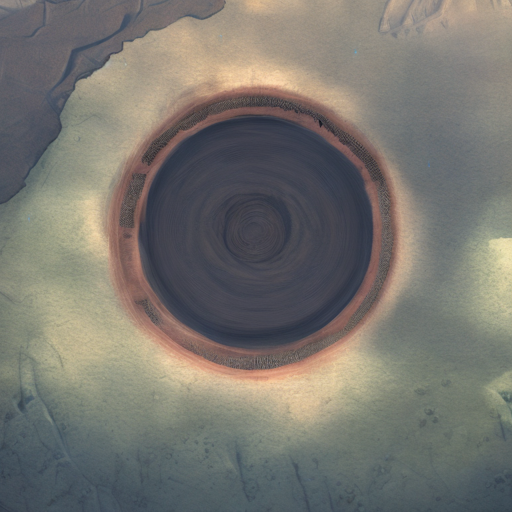

hyper realistic photo of very friendly and dystopian crater





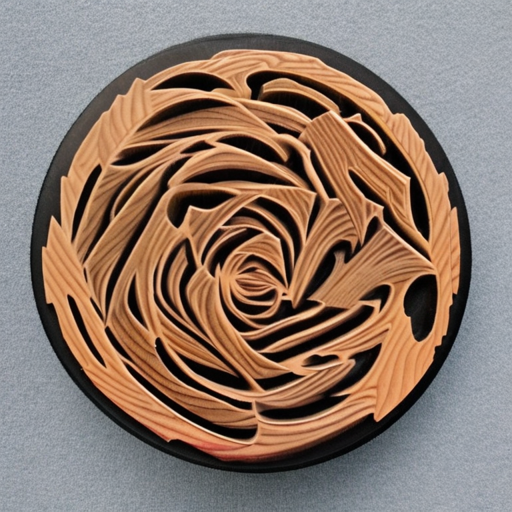

ramen carved out of fractal rose ebony, in the style of hudson river school





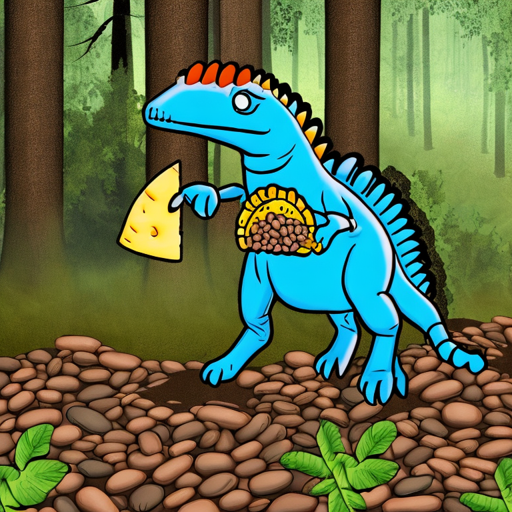

ultrasaurus holding a black bean taco in the woods, near an identical cheneosaurus





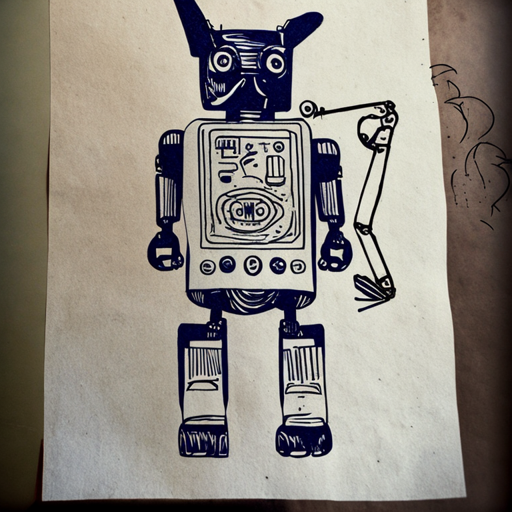

a thundering retro robot crane inks on parchment with a droopy french bulldog





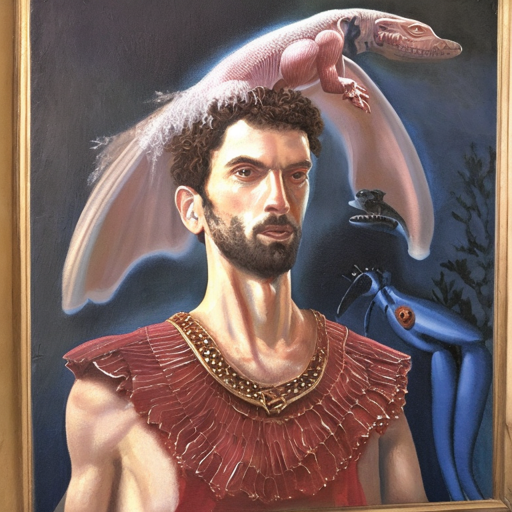

portrait painting of a shimmering greek hero, next to a loud frill-necked lizard





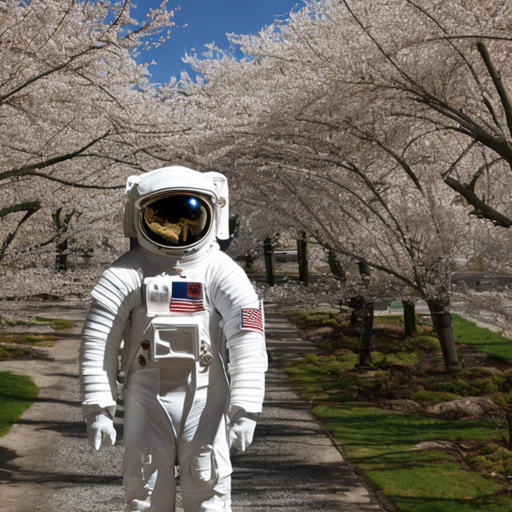

an astronaut standing on a engaging white rose, in the midst of by ivory cherry blossoms





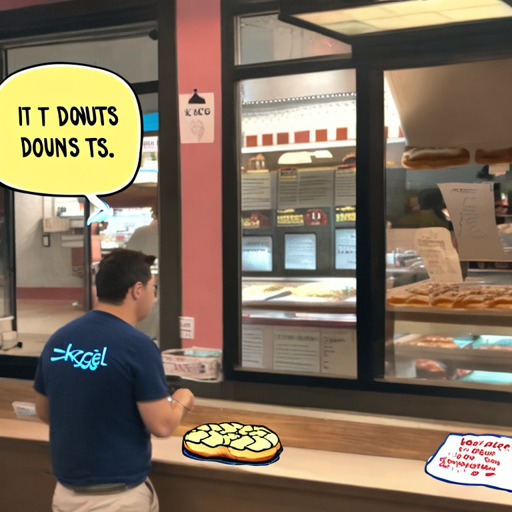

Kaggle employee Phil at a donut shop ordering all the best donuts, with a speech bubble that proclaims "Donuts. It's what's for dinner!"





In [4]:
# Loop through the prompts and display the corresponding image
for _, row in prompts_df.iterrows():
    image_path = f'{path}/images/{row["imgId"]}.png'
    prompt = row['prompt']
    display(Image.open(image_path))
    print(prompt +'\n\n\n')

In [5]:
# Check the shape of the dataframe
print(prompts_df.shape)

(7, 2)


Checking the distribution of prompt lengths:

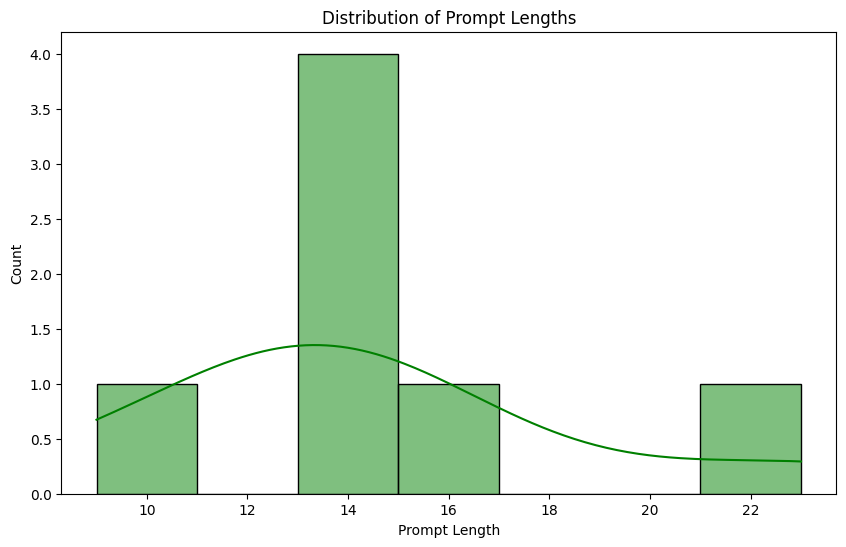

In [6]:
# Get the length of each prompt
prompt_lengths = prompts_df["prompt"].apply(lambda x: len(x.split()))

# Plot the distribution of prompt lengths
plt.figure(figsize=(10, 6))
sns.histplot(prompt_lengths, kde=True, color="green")
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Prompt Length")
plt.show()

This code calculates the length of each prompt and plots the distribution of prompt lengths using seaborn's histplot() function. This will give us an idea of how long or short the prompts are and their distribution.

We can also check the most common words in the prompts using word clouds. Here's some code to generate a word cloud:

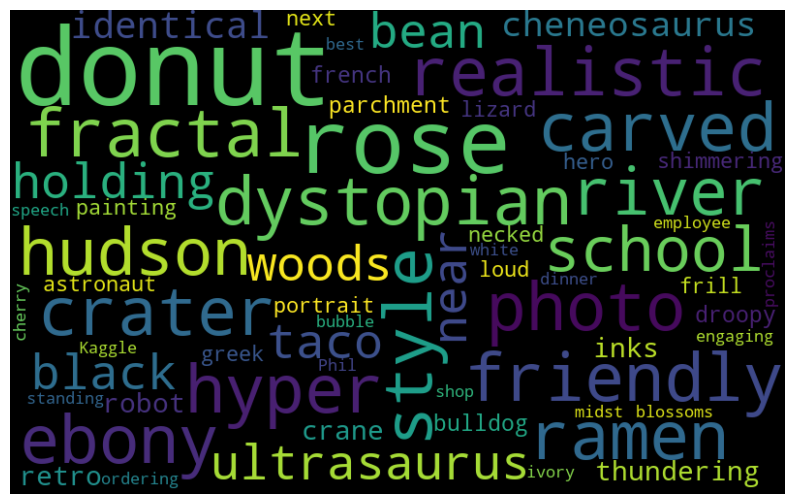

In [7]:
# Join all the prompts together into a single string
text = " ".join(prompt for prompt in prompts_df.prompt)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# **Preprocessing**

This code will load all the images in the 'images' directory, resize them to the target size, normalize the pixel values, and store them in a numpy array. We can then use this array as input to your deep learning model.

In [8]:
# Define the path to the images directory
images_path = '/kaggle/input/stable-diffusion-image-to-prompts/images'

# Define the target size for the images
target_size = (256, 256)

# Define a list to store the preprocessed images
preprocessed_images = []

# Loop through the images in the directory
for image_file in os.listdir(images_path):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(images_path, image_file))
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Convert the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.
    # Add the preprocessed image to the list
    preprocessed_images.append(image)

# Convert the list of preprocessed images to a numpy array
preprocessed_images = np.array(preprocessed_images)

In [9]:
import cv2
import os
import numpy as np

# Define the path to the directory to save the images
new_path = '/kaggle/working/preprocessed-images'

# Create the directory if it doesn't exist
if not os.path.exists(new_path):
    os.makedirs(new_path)

# Loop through the images in the input directory
for image_file in os.listdir(images_path):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(images_path, image_file))
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Convert the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.
    # Get the original filename without the extension
    name, ext = os.path.splitext(image_file)
    # Save the image with the original filename
    image_path = os.path.join(new_path, f"{name}.png")
    cv2.imwrite(image_path, np.clip(image * 255, 0, 255).astype('uint8'))


# Loading Pretrained BLIP Model

In [10]:
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/transformers* 
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/hugging*

Processing /kaggle/input/lavis-pretrained/salesforce-lavis/transformers-4.26.1-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.1
    Uninstalling transformers-4.28.1:
      Successfully uninstalled transformers-4.28.1
Processing /kaggle/input/lavis-pretrained/salesforce-lavis/huggingface_hub-0.12.0-py3-none-any.whl
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.4
    Uninstalling huggingface-hub-0.13.4:
      Successfully uninstalled huggingface-hub-0.13.4


In [11]:
from transformers import AutoProcessor, BlipForConditionalGeneration

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1146, in _get_module
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 992, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_

In [ ]:
processor = AutoProcessor.from_pretrained("/kaggle/input/blip-pretrained-model/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("/kaggle/input/blip-pretrained-model/blip-image-captioning-large")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

# Looking at a few examples

In [ ]:
sample_submission = pd.read_csv(path / 'sample_submission.csv', index_col='imgId_eId')

In [ ]:
def load_image_paths(image_dir, image_ids):
    # Initialize an empty list to store the image paths
    image_path_list = []

    # Initialize an empty set to keep track of unique image IDs
    image_set = set()

    # Loop through each image ID
    for image_id in image_ids:
        # If the image ID has already been added, skip it
        if image_id in image_set:
            continue

        # Add the image ID to the set to mark it as added
        image_set.add(image_id)

        # Generate the path to the image file and add it to the list
        image_path = f"{image_dir}/{image_id}.png"
        image_path_list.append(image_path)

    # Return the list of image paths
    return image_path_list

In [ ]:
# Split the index values and extract the image IDs
image_ids = [val.split("_")[0] for val in sample_submission.index]

# Set the image directory path
image_dir =  f'/kaggle/working/preprocessed-images'

# Load the image paths using the load_image_paths function
image_path_list = load_image_paths(image_dir, image_ids)

# Print the image path list
image_path_list

In [ ]:
# Loop through each image path and generate prompts
for image_path in image_path_list:
    # Open the image file and convert it to RGB
    raw_img = Image.open(image_path).convert("RGB")

    # Get the pixel values for the image
    pixel_values = processor(images=[raw_img], return_tensors="pt").pixel_values.to(device)

    # Generate the prompts using the model
    out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
    prompts = processor.batch_decode(out, skip_special_tokens=True)

    # Display the image and prompts
    display(raw_img)
    print(f"Grenerated Prompt: {prompts}\n\n\n")

Loading Sentence-Transformer Model for embedding

In [ ]:
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

sample_submission = pd.read_csv(path / 'sample_submission.csv', index_col='imgId_eId')

In [ ]:
# load sentence transformer model
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

Defining function load by batch

In [ ]:
def make_batches(l, batch_size=16):
    for i in range(0, len(l), batch_size):
        yield l[i:i + batch_size]

In [ ]:
images = os.listdir(path/"images")
image_ids = [i.split('.')[0] for i in images]

EMBEDDING_LENGTH = 384
eIds = list(range(EMBEDDING_LENGTH))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(image_ids, EMBEDDING_LENGTH),
        np.tile(range(EMBEDDING_LENGTH), len(image_ids)))]

# Make predictions


In [ ]:
BATCH_SIZE = 16

submissions = []
for batch in make_batches(images, BATCH_SIZE):
    images_batch = []
    for i, image in enumerate(batch):
        images_batch.append(Image.open(path/"images"/image).convert("RGB"))

    pixel_values = processor(images=images_batch, return_tensors="pt").pixel_values.to(device)
    out = model.generate(pixel_values=pixel_values, max_length=20, min_length=5)
    prompts = processor.batch_decode(out, skip_special_tokens=True)
    
    # Calculate embeddings for submission
    embeddings = st_model.encode(prompts).flatten()
    submissions.extend(embeddings)

Checking the cosine similarity score. Make sure to comment out this section for submission. 

In [ ]:
'''# cosine similarity

reference_prompts=prompts_df['prompt']
reference_prompts=reference_prompts.to_list()
reference_prompts'''

In [ ]:
#prompts

In [ ]:
'''# Pair the image IDs with the generated prompts
id_prompt_pairs = zip(image_ids, prompts)

# Sort the pairs based on image ID
sorted_pairs = sorted(id_prompt_pairs, key=lambda x: x[0])

# Separate the image IDs and sorted prompts into two lists
sorted_image_ids, sorted_generated_prompts = zip(*sorted_pairs)'''

In [ ]:
#sorted_generated_prompts

In [ ]:
'''from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = np.zeros((len(sorted_generated_prompts), len(reference_prompts)))

for i, prompt in enumerate(sorted_generated_prompts):
    for j, ref_prompt in enumerate(reference_prompts):
        prompt_embedding = st_model.encode(prompt).flatten()
        ref_prompt_embedding = st_model.encode(ref_prompt).flatten()
        similarity_scores[i][j] = cosine_similarity(prompt_embedding.reshape(1, -1), ref_prompt_embedding.reshape(1, -1))[0][0]'''

In [ ]:
#similarity_scores # each row corresponds to a prompt and each column corresponds to a reference prompt

In [ ]:
'''mean_similarity = np.mean(similarity_scores)
median_similarity = np.median(similarity_scores)
std_similarity = np.std(similarity_scores)

print(f"Mean similarity: {mean_similarity:.2f}")
print(f"Median similarity: {median_similarity:.2f}")
print(f"Standard deviation of similarity: {std_similarity:.2f}")'''

In [ ]:
'''highest_similarity_indices = np.argmax(similarity_scores, axis=1)

for i, index in enumerate(highest_similarity_indices):
    print(f"Generated Prompt {i+1} has highest similarity with Reference Prompt {i+1}: {similarity_scores[i][index]:.2f}")'''

In [ ]:
submission = pd.DataFrame({"imgId_eId":imgId_eId, "val": submissions})

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
sample_submission.head()

Reference: https://www.kaggle.com/code/bibanh/blip-0-40057-baseline-blip-large-pretrained